In [1]:
import math
import json
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
# from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
# import tensorflow as tf
from tqdm import tqdm
from matplotlib import rc
from pylab import rcParams
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
%matplotlib inline
%config InlineBackend. figure_format='retina'
sns.set(style='darkgrid', palette='muted', font_scale=1.2, rc={"axes.facecolor": "#2E2E2E", "axes.grid": True, "grid.color": "#333333", "axes.edgecolor": "#424242"})
color_pal = ['#FF6E40', '#FFEA00', '#1DE9B6', '#00E5FF', '#D500F9']
sns.set_palette(sns.color_palette(color_pal))
rcParams['figure.figsize' ] = 14, 7
rcParams['text.color'] = 'black'       # Titles and text
rcParams['axes.labelcolor'] = 'white'  # Axis labels
rcParams['xtick.color'] = 'black'      # X-axis tick labels
rcParams['ytick.color'] = 'black'
tqdm. pandas ()

In [3]:
train_df_scaled = pd.read_csv("Alibaba_random_500/train.csv")
val_df_scaled = pd.read_csv("Alibaba_random_500/val.csv")
test_df_scaled = pd.read_csv("Alibaba_random_500/test.csv") 

In [4]:
train_df_scaled.shape, val_df_scaled.shape, test_df_scaled.shape # 1999990

((16043024, 13), (3437791, 13), (3437792, 13))

In [6]:
train_df_scaled=train_df_scaled[-(int)(len(train_df_scaled)/5):]
val_df_scaled=val_df_scaled[:(int)(len(test_df_scaled)/5)]
test_df_scaled=test_df_scaled[:(int)(len(test_df_scaled)/5)]
train_df_scaled.shape, val_df_scaled.shape, test_df_scaled.shape

((641720, 13), (137511, 13), (137511, 13))

In [7]:
train_df_scaled.columns

Index(['hour', 'minute', 'second', 'day', 'weekday', 'mem_util_percent',
       'mem_gps', 'mkpi', 'net_in', 'net_out', 'disk_io_percent',
       'cpu_difference', 'cpu_util_percent'],
      dtype='object')

In [8]:
timesteps = 59 # Define timesteps: for nxn window choose 2n-1 
columns_to_scale = ['hour', 'minute', 'second', 'day', 'weekday', 'mem_util_percent',
       'mem_gps', 'mkpi', 'net_in', 'net_out', 'disk_io_percent',
       'cpu_difference', 'cpu_util_percent']

forecast_horizon = 10  # Number of future steps to predict

def create_sequences(data, timesteps, target_idx, horizon):
    X, y = [], []
    for i in tqdm(range(timesteps, len(data) - horizon + 1)):
        X.append(data[i - timesteps:i])
        y.append(data[i:i + horizon, target_idx])  # Get next 30 values
    return np.array(X), np.array(y)

cpu_data = train_df_scaled[columns_to_scale].values  # Extract 'cpu_usage' for sequence creation
X_train, y_train = create_sequences(cpu_data, timesteps, -1, forecast_horizon)  # Create sequences

cpu_data = val_df_scaled[columns_to_scale].values  # Extract 'cpu_usage' for sequence creation
X_val, y_val = create_sequences(cpu_data, timesteps, -1, forecast_horizon)  # Create sequences

cpu_data = test_df_scaled[columns_to_scale].values  # Extract 'cpu_usage' for sequence creation
X_test, y_test = create_sequences(cpu_data, timesteps, -1, forecast_horizon)  # Create sequences


100%|██████████| 137443/137443 [00:00<00:00, 1963479.99it/s]


In [9]:
features = X_train.shape[2]
features

13

In [10]:
# Prepare Data (Example: replace with actual dataset)
X_train = torch.tensor(X_train, dtype=torch.float32).clone().detach()
y_train = torch.tensor(y_train, dtype=torch.float32).clone().detach()
X_val = torch.tensor(X_val, dtype=torch.float32).clone().detach()
y_val = torch.tensor(y_val, dtype=torch.float32).clone().detach()
X_test = torch.tensor(X_test, dtype=torch.float32).clone().detach()
y_test = torch.tensor(y_test, dtype=torch.float32).clone().detach()

print(X_train.shape, y_train.shape)  # Should be (1000, timesteps, features) and (1000, 1)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)  # No shuffling for test data
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)  # No shuffling for test data

torch.Size([641652, 59, 13]) torch.Size([641652, 10])


In [11]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#### helper

In [12]:
def save_checkpoint(model, optimizer, epoch, loss, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at epoch {epoch+1}")

In [13]:
# Function to load checkpoint
def load_checkpoint(model, optimizer, path):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
        print(f"Checkpoint loaded: Resuming from epoch {start_epoch}")
        return start_epoch
    return 0  # If no checkpoint, start from epoch 0

In [14]:
# Function to compute validation loss
def evaluate_model_trianing(model, val_loader, loss_fn):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No need to track gradients during validation
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            # y_batch = y_batch.view(-1, 1)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
    return val_loss / len(val_loader)

In [15]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=10, checkpoint_interval=2, patience=5, path="checkpoints"):
    start_epoch = load_checkpoint(model, optimizer, path)
    model.train()
    print("#### TRAINING STARTED ####")

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    start_time = time.time()

    for epoch in range(start_epoch, epochs):
        model.train()
        running_train_loss = 0.0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        val_loss = evaluate_model_trianing(model, val_loader, loss_fn)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            save_checkpoint(model, optimizer, epoch, val_loss, path)
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"⚠️ Early stopping at epoch {epoch+1} (no improvement in val loss for {patience} epochs).")
            break

        if (epoch + 1) % checkpoint_interval == 0:
            save_checkpoint(model, optimizer, epoch, val_loss, path)

    # Final stats
    total_time = round(time.time() - start_time, 2)
    print("\n#### TRAINING COMPLETE ####")
    print(f"Total Time Elapsed: {total_time} seconds")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"Final Train Loss: {train_losses[-1]:.4f}")
    print(f"Final Val Loss: {val_losses[-1]:.4f}")

    # Plotting Loss Curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='x')
    plt.title("Loss vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [16]:
# Function to load model from checkpoint
def load_model_from_checkpoint(model, checkpoint_path, device="cpu"):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Checkpoint loaded from {checkpoint_path}")
    else:
        print("No checkpoint found! Using randomly initialized model.")
    return model

In [17]:
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

def evaluate_model(model, test_loader, checkpoint_path, device="cpu"):
    model = load_model_from_checkpoint(model, checkpoint_path, device)
    model.to(device)
    model.eval()

    all_predictions = []
    all_targets = []

    total_inference_time = 0.0
    total_samples = 0

    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc="Evaluating"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            start_time = time.perf_counter()
            y_pred = model(X_batch)
            end_time = time.perf_counter()

            total_inference_time += (end_time - start_time)
            total_samples += X_batch.size(0)

            all_predictions.append(y_pred.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    # Convert to NumPy
    predictions_np = np.concatenate(all_predictions, axis=0)
    y_test_np = np.concatenate(all_targets, axis=0)

    # Convert to Torch tensors for loss calculations
    predictions_tensor = torch.tensor(predictions_np, dtype=torch.float32, device=device)
    y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32, device=device)

    if predictions_tensor.shape != y_test_tensor.shape:
        print(f"⚠️ Shape mismatch! Predictions: {predictions_tensor.shape}, Targets: {y_test_tensor.shape}")
        y_test_tensor = y_test_tensor.view_as(predictions_tensor)

    # Calculate metrics
    mae = mean_absolute_error(y_test_np, predictions_np)
    rmse = np.sqrt(mean_squared_error(y_test_np, predictions_np))
    huber_loss = nn.HuberLoss()(predictions_tensor, y_test_tensor).item()
    mse_loss = nn.MSELoss()(predictions_tensor, y_test_tensor).item()
    avg_inference_time = (total_inference_time / total_samples) * 1000  # ms per sample

    # Print metrics
    print("\n##### Evaluation Metrics #####")
    print(f"Test MAE         : {mae:.4f}")
    print(f"Test RMSE        : {rmse:.4f}")
    print(f"Test Huber Loss  : {huber_loss:.4f}")
    print(f"Test MSE Loss    : {mse_loss:.4f}")
    print(f"Avg Inference Time per Sample: {avg_inference_time:.4f} ms")
    print(f"Total Evaluation Time        : {total_inference_time:.2f} seconds")

    return predictions_np


In [18]:
def print_model_summary(model):
    total_params = 0
    print(f"{'Layer':<40} {'Param Shape':<30} {'# Params'}")
    print("-" * 80)

    for name, param in model.named_parameters():
        if param.requires_grad:
            param_count = param.numel()
            total_params += param_count
            print(f"{name:<40} {str(list(param.shape)):<30} {param_count}")

    print("-" * 80)
    print(f"{'Total Trainable Params':<40} {'':<30} {total_params:,}")


In [19]:
def visualize_target_sequence(X, y_true, y_pred=None, sample_idx=0, feature_idx=-1):
    """
    Visualizes the input sequence and forecast horizon for a selected sample.

    Args:
        X (np.ndarray): Input sequences of shape (samples, timesteps, features).
        y_true (np.ndarray): Ground truth targets of shape (samples, horizon).
        y_pred (np.ndarray, optional): Predicted targets of shape (samples, horizon). Default is None.
        sample_idx (int): Index of the sample to visualize.
        feature_idx (int): Index of the feature to plot from X (default: last feature).
    """
    input_sequence = X[sample_idx, :, feature_idx]
    future_targets = y_true[sample_idx]
    
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(input_sequence)), input_sequence, label='Input: cpu_difference (past)')
    plt.plot(range(len(input_sequence), len(input_sequence) + len(future_targets)),
             future_targets, label='Target: cpu_difference (future)', linestyle='--')

    if y_pred is not None:
        future_preds = y_pred[sample_idx]
        plt.plot(range(len(input_sequence), len(input_sequence) + len(future_preds)),
                 future_preds, label='Prediction: cpu_difference', linestyle='-.', color='red')

    plt.axvline(x=len(input_sequence)-1, color='gray', linestyle=':', label='Prediction Start')
    plt.xlabel('Timestep')
    plt.ylabel('cpu_difference')
    plt.title(f'cpu_difference Forecast (Sample #{sample_idx})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### MCDFN

In [20]:
import torch
import torch.nn as nn

class MCDFN(nn.Module):
    def __init__(self, input_shape=(timesteps, features)):
        super(MCDFN, self).__init__()
        self.num_features = input_shape[1]
        
        # CNN Branch
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=self.num_features, out_channels=352, kernel_size=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(10208, 128),
            nn.ReLU()
        )
        
        # BiLSTM Branch
        self.bilstm = nn.LSTM(input_size=self.num_features, hidden_size=192, batch_first=True, bidirectional=True)
        self.bilstm_dropout = nn.Dropout(0.2)
        
        # BiGRU Branch
        self.bigru = nn.GRU(input_size=self.num_features, hidden_size=64, batch_first=True, bidirectional=True)
        self.bigru_dropout = nn.Dropout(0.4)
        
        # Multi-Layer LSTM Branch
        self.lstm1 = nn.LSTM(input_size=self.num_features, hidden_size=64, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.lstm_dropout = nn.Dropout(0.2)
        
        # Fully Connected Layer
        self.fc = nn.Sequential(
            nn.Linear(128 + 192 * 2 + 64 * 2 + 64, 30),  # Concatenated features
            nn.Linear(30, forecast_horizon),  # Final output
        )
    
    def forward(self, x):
        # print(f'Before CNN: {x.shape}, {self.num_features}')
        x_cnn = self.cnn(x.permute(0, 2, 1))  # (batch, num_features, time_steps)
        # print(f'After CNN: {x_cnn.shape}')
        
        x_bilstm, _ = self.bilstm(x)
        x_bilstm = self.bilstm_dropout(x_bilstm[:, -1, :])
        
        x_bigru, _ = self.bigru(x)
        x_bigru = self.bigru_dropout(x_bigru[:, -1, :])
        
        x_lstm1, _ = self.lstm1(x)
        x_lstm2, _ = self.lstm2(x_lstm1)
        x_lstm = self.lstm_dropout(x_lstm2[:, -1, :])
        
        x_concat = torch.cat([x_cnn, x_bilstm, x_bigru, x_lstm], dim=1)
        output = self.fc(x_concat)
        return output # Reshape to (batch, 30, 1)

In [21]:

model = MCDFN((timesteps, features)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
cnn.0.weight                             [352, 13, 1]                   4576
cnn.0.bias                               [352]                          352
cnn.4.weight                             [128, 10208]                   1306624
cnn.4.bias                               [128]                          128
bilstm.weight_ih_l0                      [768, 13]                      9984
bilstm.weight_hh_l0                      [768, 192]                     147456
bilstm.bias_ih_l0                        [768]                          768
bilstm.bias_hh_l0                        [768]                          768
bilstm.weight_ih_l0_reverse              [768, 13]                      9984
bilstm.weight_hh_l0_reverse              [768, 192]                     147456
bilstm.bias_ih_l0_reverse                [768]                   

In [22]:
checkpoint_path = "ck_10/MCDFN_alibaba.pth"

#### TRAINING STARTED ####


Epoch 1/100: 100%|██████████| 10025/10025 [05:46<00:00, 28.92it/s]


Epoch 01 | Train Loss: 0.0182 | Val Loss: 0.0072
Checkpoint saved at epoch 1


Epoch 2/100: 100%|██████████| 10025/10025 [05:59<00:00, 27.91it/s]


Epoch 02 | Train Loss: 0.0069 | Val Loss: 0.0069
Checkpoint saved at epoch 2
Checkpoint saved at epoch 2


Epoch 3/100: 100%|██████████| 10025/10025 [05:53<00:00, 28.34it/s]


Epoch 03 | Train Loss: 0.0066 | Val Loss: 0.0067
Checkpoint saved at epoch 3


Epoch 4/100: 100%|██████████| 10025/10025 [05:44<00:00, 29.11it/s]


Epoch 04 | Train Loss: 0.0066 | Val Loss: 0.0066
Checkpoint saved at epoch 4
Checkpoint saved at epoch 4


Epoch 5/100: 100%|██████████| 10025/10025 [05:55<00:00, 28.21it/s]


Epoch 05 | Train Loss: 0.0066 | Val Loss: 0.0069


Epoch 6/100: 100%|██████████| 10025/10025 [05:45<00:00, 28.98it/s]


Epoch 06 | Train Loss: 0.0066 | Val Loss: 0.0066
Checkpoint saved at epoch 6


Epoch 7/100: 100%|██████████| 10025/10025 [05:43<00:00, 29.16it/s]


Epoch 07 | Train Loss: 0.0066 | Val Loss: 0.0068


Epoch 8/100: 100%|██████████| 10025/10025 [05:56<00:00, 28.11it/s]


Epoch 08 | Train Loss: 0.0066 | Val Loss: 0.0066
Checkpoint saved at epoch 8
Checkpoint saved at epoch 8


Epoch 9/100: 100%|██████████| 10025/10025 [05:42<00:00, 29.31it/s]


Epoch 09 | Train Loss: 0.0066 | Val Loss: 0.0068


Epoch 10/100: 100%|██████████| 10025/10025 [05:57<00:00, 28.01it/s]


Epoch 10 | Train Loss: 0.0066 | Val Loss: 0.0067
Checkpoint saved at epoch 10


Epoch 11/100: 100%|██████████| 10025/10025 [05:57<00:00, 28.00it/s]


Epoch 11 | Train Loss: 0.0065 | Val Loss: 0.0070


Epoch 12/100: 100%|██████████| 10025/10025 [05:43<00:00, 29.17it/s]


Epoch 12 | Train Loss: 0.0065 | Val Loss: 0.0067
Checkpoint saved at epoch 12


Epoch 13/100: 100%|██████████| 10025/10025 [05:54<00:00, 28.24it/s]


Epoch 13 | Train Loss: 0.0065 | Val Loss: 0.0068


Epoch 14/100: 100%|██████████| 10025/10025 [05:44<00:00, 29.10it/s]


Epoch 14 | Train Loss: 0.0065 | Val Loss: 0.0067
Checkpoint saved at epoch 14


Epoch 15/100: 100%|██████████| 10025/10025 [05:45<00:00, 29.01it/s]


Epoch 15 | Train Loss: 0.0065 | Val Loss: 0.0067


Epoch 16/100: 100%|██████████| 10025/10025 [04:24<00:00, 37.96it/s]


Epoch 16 | Train Loss: 0.0065 | Val Loss: 0.0069
Checkpoint saved at epoch 16


Epoch 17/100: 100%|██████████| 10025/10025 [05:46<00:00, 28.92it/s]


Epoch 17 | Train Loss: 0.0065 | Val Loss: 0.0067


Epoch 18/100: 100%|██████████| 10025/10025 [05:52<00:00, 28.41it/s]


Epoch 18 | Train Loss: 0.0065 | Val Loss: 0.0067
⚠️ Early stopping at epoch 18 (no improvement in val loss for 10 epochs).

#### TRAINING COMPLETE ####
Total Time Elapsed: 6976.96 seconds
Best Validation Loss: 0.0066
Final Train Loss: 0.0065
Final Val Loss: 0.0067


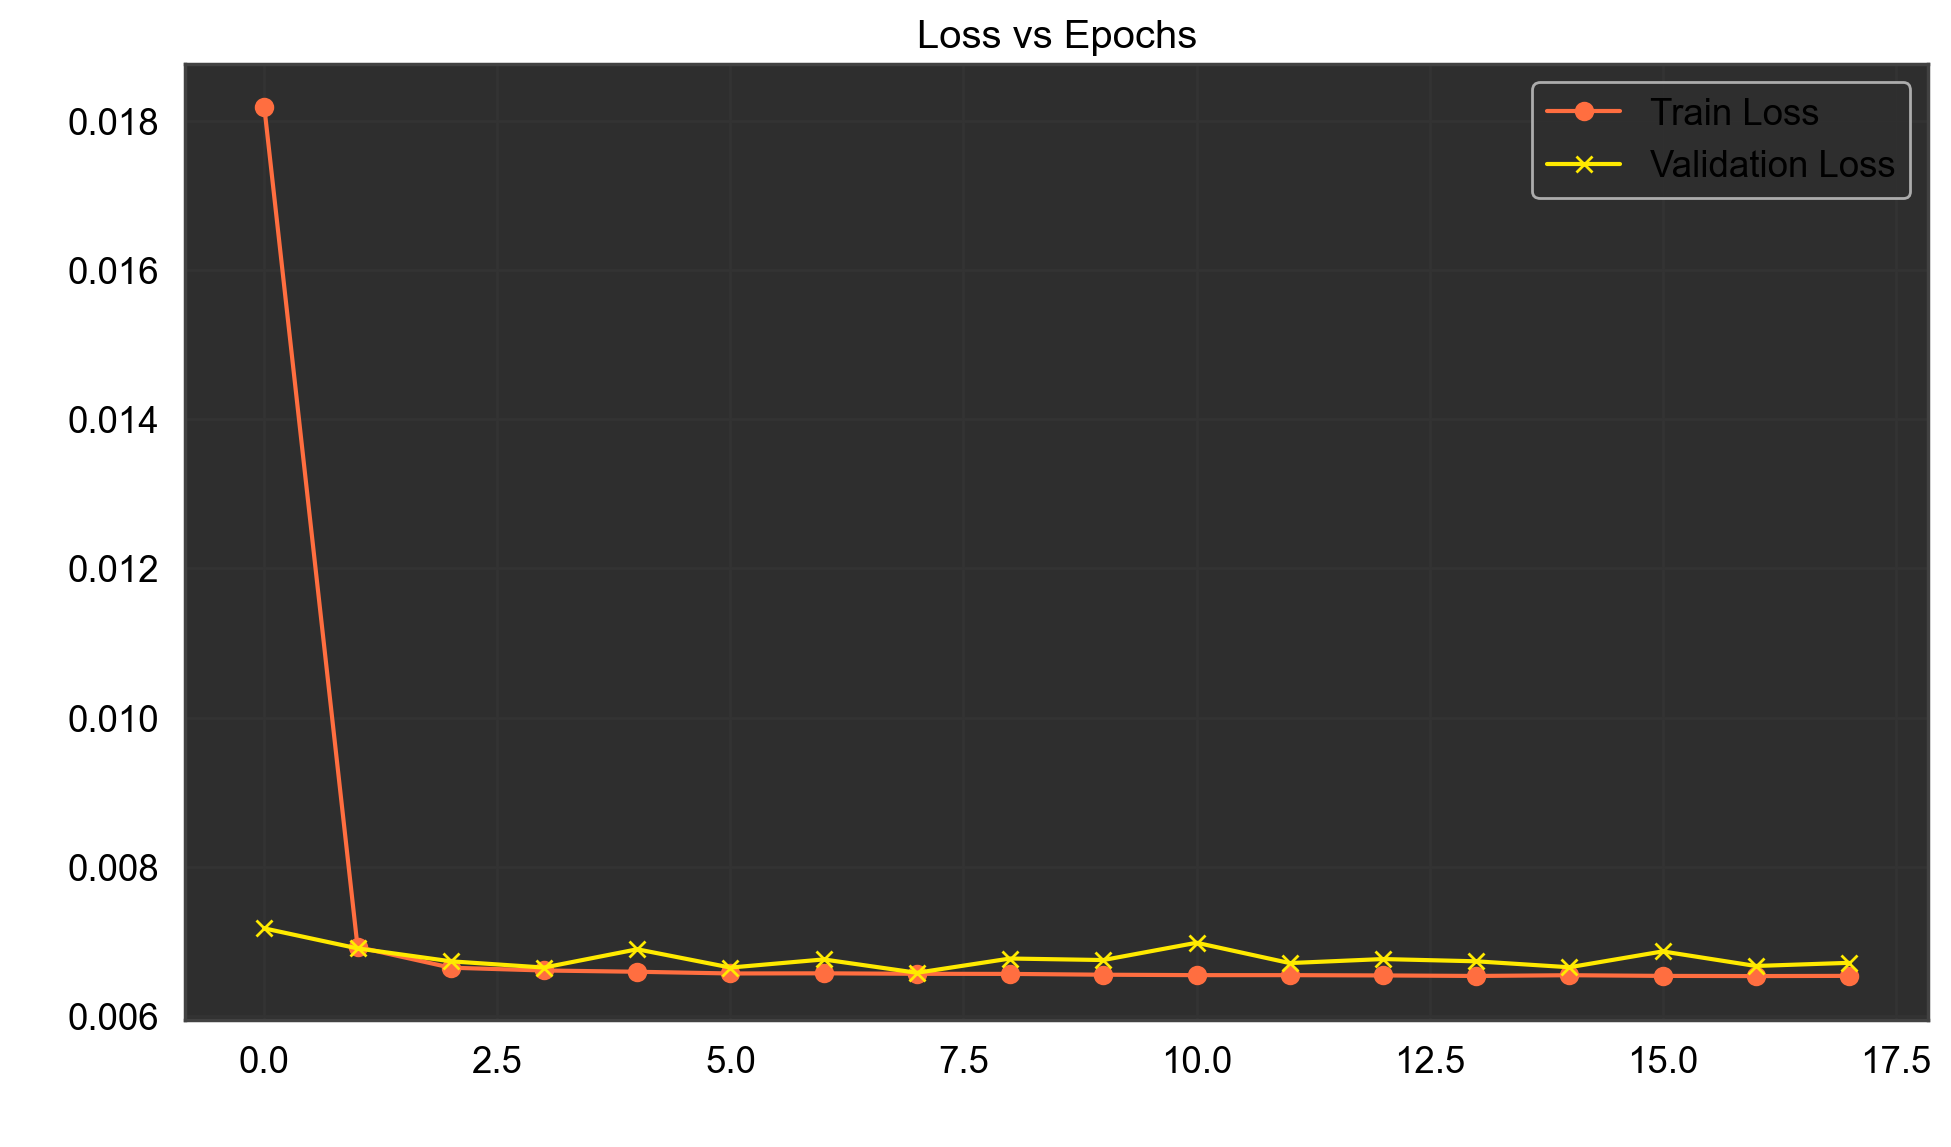

In [23]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10, path=checkpoint_path)

In [24]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode

C:\Users\User\AppData\Local\Temp\ipykernel_27028\1956403801.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

MCDFN(
  (cnn): Sequential(
    (0): Conv1d(13, 352, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=10208, out_features=128, bias=True)
    (5): ReLU()
  )
  (bilstm): LSTM(13, 192, batch_first=True, bidirectional=True)
  (bilstm_dropout): Dropout(p=0.2, inplace=False)
  (bigru): GRU(13, 64, batch_first=True, bidirectional=True)
  (bigru_dropout): Dropout(p=0.4, inplace=False)
  (lstm1): LSTM(13, 64, batch_first=True)
  (lstm2): LSTM(64, 64, batch_first=True)
  (lstm_dropout): Dropout(p=0.2, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=704, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=10, bias=True)
  )
)

In [25]:
evaluate_model(model, test_loader, checkpoint_path, device=device)

C:\Users\User\AppData\Local\Temp\ipykernel_27028\1770941795.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

Checkpoint loaded from ck_10/MCDFN_alibaba.pth


Evaluating: 100%|██████████| 2147/2147 [00:42<00:00, 49.97it/s]


##### Evaluation Metrics #####
Test MAE         : 0.0584
Test RMSE        : 0.0829
Test Huber Loss  : 0.0034
Test MSE Loss    : 0.0069
Avg Inference Time per Sample: 0.0130 ms
Total Evaluation Time        : 1.79 seconds


array([[0.03605208, 0.053711  , 0.05885217, ..., 0.08291109, 0.09444207,
        0.09655161],
       [0.03817913, 0.04802874, 0.05418301, ..., 0.08408736, 0.09606709,
        0.09160896],
       [0.03356621, 0.05054525, 0.06542525, ..., 0.0945608 , 0.0906315 ,
        0.09224294],
       ...,
       [0.16361776, 0.1717224 , 0.16895923, ..., 0.16761245, 0.17225762,
        0.17477125],
       [0.16699035, 0.16637823, 0.1651105 , ..., 0.17028004, 0.17534985,
        0.17041458],
       [0.17465492, 0.17848954, 0.18172798, ..., 0.18709119, 0.17722942,
        0.1771028 ]], dtype=float32)

#### SE_LSTM_DNN

In [26]:
class SE(nn.Module):
    def __init__(self, in_channels, ratio):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # squeeze
            nn.Conv2d(in_channels, in_channels//ratio, kernel_size=(1, 1)),  # compress
            nn.ReLU(),
            nn.Conv2d(in_channels//ratio, in_channels, kernel_size=(1, 1)),  # excitation
            nn.Sigmoid(),
        )

    def forward(self, X):
        return self.se(X)

class SENet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, ratio):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        self.se = SE(out_channels, ratio)
        self.tanh = nn.Tanh()

    def forward(self, X):
        X = self.conv(X)
        coef = self.se(X)
        X = X * coef
        return self.tanh(X)

class SE_LSTM_DNN(nn.Module):
    def __init__(self, learning_rate=0.001, epochs=100, batch_size=50, random_state=0, device='cpu', seq_len=60, sub_seq_len=30):
        super().__init__()
        # self.model_name = "se_lstm_dnn" if sub_seq_len == 30 else "se_lstm_dnn_%d" % sub_seq_len

        self.input_size = int((int(sub_seq_len/2)+1)/4)
        self.senet = SENet(1, 16, (1, 4), (1, 4), 4)
        self.lstm = nn.LSTM(input_size=48, hidden_size=64)
        self.dnn = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=64, out_features=32),
            nn.Tanh(),
            nn.Linear(in_features=32, out_features=forecast_horizon),
        )

    def forward(self, X):
        X = X.unsqueeze(1)
        X = self.senet(X)
        H = X.permute(2, 0, 1, 3).flatten(2)
        _, (h, _) = self.lstm(H)
        y = self.dnn(h.squeeze(0))
        return y


In [27]:
model = SE_LSTM_DNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
senet.conv.weight                        [16, 1, 1, 4]                  64
senet.conv.bias                          [16]                           16
senet.se.se.1.weight                     [4, 16, 1, 1]                  64
senet.se.se.1.bias                       [4]                            4
senet.se.se.3.weight                     [16, 4, 1, 1]                  64
senet.se.se.3.bias                       [16]                           16
lstm.weight_ih_l0                        [256, 48]                      12288
lstm.weight_hh_l0                        [256, 64]                      16384
lstm.bias_ih_l0                          [256]                          256
lstm.bias_hh_l0                          [256]                          256
dnn.1.weight                             [32, 64]                       2048
dnn.

In [28]:
checkpoint_path = "ck_10/SE_LSTM_DNN_alibaba.pth"

#### TRAINING STARTED ####


Epoch 1/100: 100%|██████████| 10025/10025 [02:18<00:00, 72.29it/s]


Epoch 01 | Train Loss: 0.0118 | Val Loss: 0.0115
Checkpoint saved at epoch 1


Epoch 2/100: 100%|██████████| 10025/10025 [02:20<00:00, 71.20it/s]


Epoch 02 | Train Loss: 0.0096 | Val Loss: 0.0117
Checkpoint saved at epoch 2


Epoch 3/100: 100%|██████████| 10025/10025 [02:21<00:00, 71.10it/s]


Epoch 03 | Train Loss: 0.0092 | Val Loss: 0.0118


Epoch 4/100: 100%|██████████| 10025/10025 [02:18<00:00, 72.62it/s]


Epoch 04 | Train Loss: 0.0090 | Val Loss: 0.0120
Checkpoint saved at epoch 4


Epoch 5/100: 100%|██████████| 10025/10025 [02:20<00:00, 71.10it/s]


Epoch 05 | Train Loss: 0.0089 | Val Loss: 0.0124


Epoch 6/100: 100%|██████████| 10025/10025 [02:20<00:00, 71.12it/s]


Epoch 06 | Train Loss: 0.0088 | Val Loss: 0.0116
Checkpoint saved at epoch 6


Epoch 7/100: 100%|██████████| 10025/10025 [02:19<00:00, 71.97it/s]


Epoch 07 | Train Loss: 0.0087 | Val Loss: 0.0121


Epoch 8/100: 100%|██████████| 10025/10025 [02:19<00:00, 71.92it/s]


Epoch 08 | Train Loss: 0.0085 | Val Loss: 0.0120
Checkpoint saved at epoch 8


Epoch 9/100: 100%|██████████| 10025/10025 [02:19<00:00, 72.01it/s]


Epoch 09 | Train Loss: 0.0085 | Val Loss: 0.0115
Checkpoint saved at epoch 9


Epoch 10/100: 100%|██████████| 10025/10025 [02:18<00:00, 72.60it/s]


Epoch 10 | Train Loss: 0.0085 | Val Loss: 0.0119
Checkpoint saved at epoch 10


Epoch 11/100: 100%|██████████| 10025/10025 [02:20<00:00, 71.39it/s]


Epoch 11 | Train Loss: 0.0083 | Val Loss: 0.0120


Epoch 12/100: 100%|██████████| 10025/10025 [02:20<00:00, 71.46it/s]


Epoch 12 | Train Loss: 0.0084 | Val Loss: 0.0149
Checkpoint saved at epoch 12


Epoch 13/100: 100%|██████████| 10025/10025 [02:18<00:00, 72.23it/s]


Epoch 13 | Train Loss: 0.0083 | Val Loss: 0.0119


Epoch 14/100: 100%|██████████| 10025/10025 [02:20<00:00, 71.31it/s]


Epoch 14 | Train Loss: 0.0084 | Val Loss: 0.0126
Checkpoint saved at epoch 14


Epoch 15/100: 100%|██████████| 10025/10025 [02:20<00:00, 71.42it/s]


Epoch 15 | Train Loss: 0.0082 | Val Loss: 0.0134


Epoch 16/100: 100%|██████████| 10025/10025 [02:18<00:00, 72.25it/s]


Epoch 16 | Train Loss: 0.0083 | Val Loss: 0.0125
Checkpoint saved at epoch 16


Epoch 17/100: 100%|██████████| 10025/10025 [02:20<00:00, 71.56it/s]


Epoch 17 | Train Loss: 0.0081 | Val Loss: 0.0132


Epoch 18/100: 100%|██████████| 10025/10025 [02:20<00:00, 71.24it/s]


Epoch 18 | Train Loss: 0.0081 | Val Loss: 0.0147
Checkpoint saved at epoch 18


Epoch 19/100: 100%|██████████| 10025/10025 [02:19<00:00, 72.05it/s]


Epoch 19 | Train Loss: 0.0081 | Val Loss: 0.0143
⚠️ Early stopping at epoch 19 (no improvement in val loss for 10 epochs).

#### TRAINING COMPLETE ####
Total Time Elapsed: 3024.87 seconds
Best Validation Loss: 0.0115
Final Train Loss: 0.0081
Final Val Loss: 0.0143


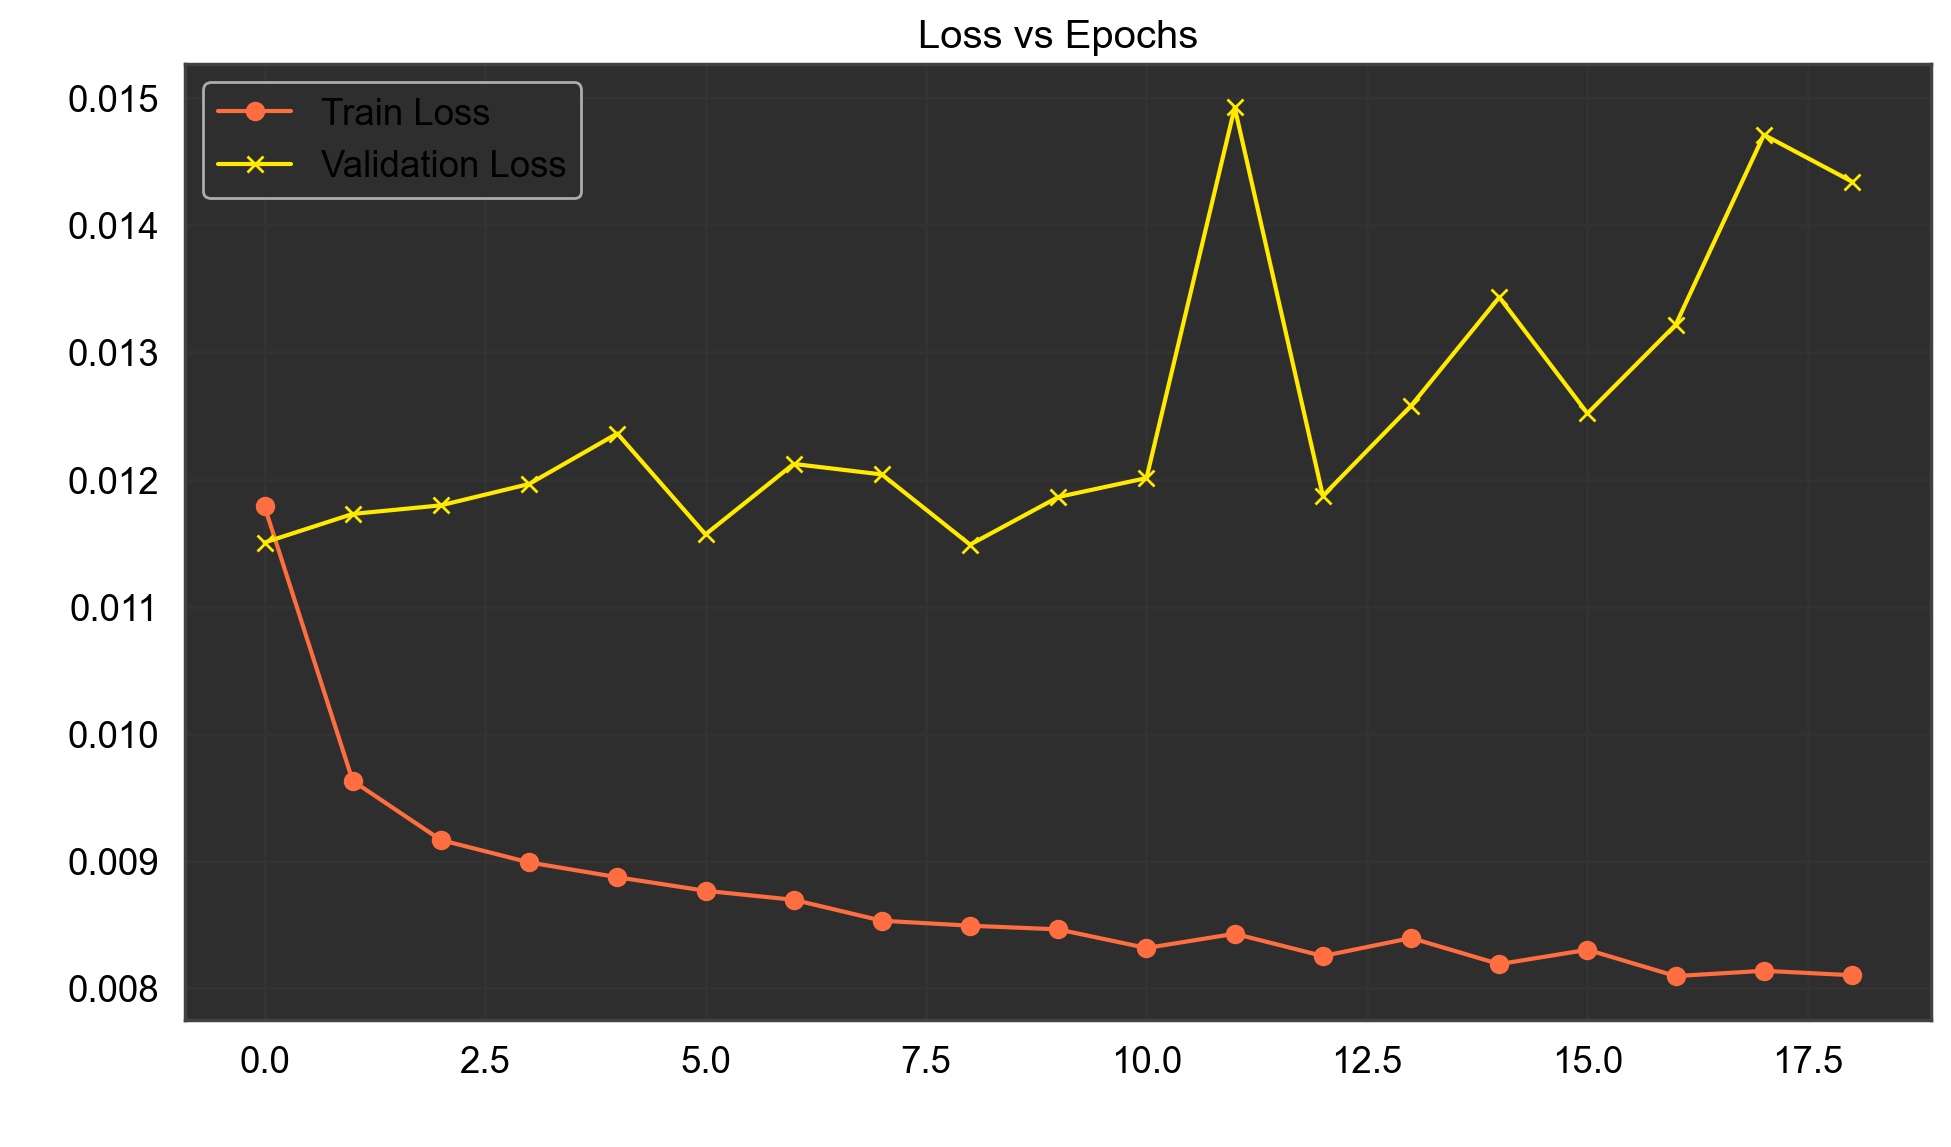

In [29]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10, path=checkpoint_path)

In [30]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode
predictions = evaluate_model(model, test_loader, checkpoint_path, device=device)

C:\Users\User\AppData\Local\Temp\ipykernel_27028\140456513.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Checkpoint loaded from ck_10/SE_LSTM_DNN_alibaba.pth


Evaluating: 100%|██████████| 2147/2147 [00:20<00:00, 102.94it/s]



##### Evaluation Metrics #####
Test MAE         : 0.0853
Test RMSE        : 0.1213
Test Huber Loss  : 0.0074
Test MSE Loss    : 0.0147
Avg Inference Time per Sample: 0.0070 ms
Total Evaluation Time        : 0.96 seconds


#### FreTS

In [35]:
class Model(nn.Module):
    def __init__(self, configs):
        super(Model, self).__init__()
        self.embed_size = 128 #embed_size
        self.hidden_size = 256 #hidden_size
        self.pre_length = configs.pred_len
        self.feature_size = configs.enc_in #channels
        self.seq_length = configs.seq_len
        self.channel_independence = configs.channel_independence
        self.sparsity_threshold = 0.01
        self.scale = 0.02
        self.embeddings = nn.Parameter(torch.randn(1, self.embed_size))
        self.r1 = nn.Parameter(self.scale * torch.randn(self.embed_size, self.embed_size))
        self.i1 = nn.Parameter(self.scale * torch.randn(self.embed_size, self.embed_size))
        self.rb1 = nn.Parameter(self.scale * torch.randn(self.embed_size))
        self.ib1 = nn.Parameter(self.scale * torch.randn(self.embed_size))
        self.r2 = nn.Parameter(self.scale * torch.randn(self.embed_size, self.embed_size))
        self.i2 = nn.Parameter(self.scale * torch.randn(self.embed_size, self.embed_size))
        self.rb2 = nn.Parameter(self.scale * torch.randn(self.embed_size))
        self.ib2 = nn.Parameter(self.scale * torch.randn(self.embed_size))

        self.fc = nn.Sequential(
            nn.Linear(self.seq_length * self.embed_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.pre_length)
        )

    # dimension extension
    def tokenEmb(self, x):
        # x: [Batch, Input length, Channel]
        x = x.permute(0, 2, 1)
        x = x.unsqueeze(3)
        # N*T*1 x 1*D = N*T*D
        y = self.embeddings
        return x * y

    # frequency temporal learner
    def MLP_temporal(self, x, B, N, L):
        # [B, N, T, D]
        x = torch.fft.rfft(x, dim=2, norm='ortho') # FFT on L dimension
        y = self.FreMLP(B, N, L, x, self.r2, self.i2, self.rb2, self.ib2)
        x = torch.fft.irfft(y, n=self.seq_length, dim=2, norm="ortho")
        return x

    # frequency channel learner
    def MLP_channel(self, x, B, N, L):
        # [B, N, T, D]
        x = x.permute(0, 2, 1, 3)
        # [B, T, N, D]
        x = torch.fft.rfft(x, dim=2, norm='ortho') # FFT on N dimension
        y = self.FreMLP(B, L, N, x, self.r1, self.i1, self.rb1, self.ib1)
        x = torch.fft.irfft(y, n=self.feature_size, dim=2, norm="ortho")
        x = x.permute(0, 2, 1, 3)
        # [B, N, T, D]
        return x

    # frequency-domain MLPs
    # dimension: FFT along the dimension, r: the real part of weights, i: the imaginary part of weights
    # rb: the real part of bias, ib: the imaginary part of bias
    def FreMLP(self, B, nd, dimension, x, r, i, rb, ib):
        o1_real = torch.zeros([B, nd, dimension // 2 + 1, self.embed_size],
                              device=x.device)
        o1_imag = torch.zeros([B, nd, dimension // 2 + 1, self.embed_size],
                              device=x.device)

        o1_real = F.relu(
            torch.einsum('bijd,dd->bijd', x.real, r) - \
            torch.einsum('bijd,dd->bijd', x.imag, i) + \
            rb
        )

        o1_imag = F.relu(
            torch.einsum('bijd,dd->bijd', x.imag, r) + \
            torch.einsum('bijd,dd->bijd', x.real, i) + \
            ib
        )

        y = torch.stack([o1_real, o1_imag], dim=-1)
        y = F.softshrink(y, lambd=self.sparsity_threshold)
        y = torch.view_as_complex(y)
        return y

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        B, T, N = x.shape
        # embedding x: [B, N, T, D]
        x = self.tokenEmb(x)
        bias = x
        # [B, N, T, D]
        if self.channel_independence == '1':
            x = self.MLP_channel(x, B, N, T)
        # [B, N, T, D]
        x = self.MLP_temporal(x, B, N, T)
        x = x + bias
        x = self.fc(x.reshape(B, N, -1)).permute(0, 2, 1)
        target_feature_idx = -1
        x = x[:, :, target_feature_idx]
        return x

In [36]:
class Configs:
    pred_len = forecast_horizon  # Example long-term prediction length
    enc_in = features  # Number of input features (channels)
    seq_len = timesteps  # Lookback window size (from FEDformer & Autoformer recommendations)
    channel_independence = '1' if pred_len >= 336 else '0'  # Apply channel independence for longer horizons
    embed_size = 128  # Embedding size d
    hidden_size = 256  # Hidden size dh
    batch_size = 32  # Default batch size (can be tuned per dataset)
    learning_rate = 0.001  # Placeholder, needs tuning on validation set


configs = Configs()
model = Model(configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
embeddings                               [1, 128]                       128
r1                                       [128, 128]                     16384
i1                                       [128, 128]                     16384
rb1                                      [128]                          128
ib1                                      [128]                          128
r2                                       [128, 128]                     16384
i2                                       [128, 128]                     16384
rb2                                      [128]                          128
ib2                                      [128]                          128
fc.0.weight                              [256, 7552]                    1933312
fc.0.bias                                [256]                    

In [37]:
checkpoint_path = "ck_10/FreTS_alibaba.pth"

#### TRAINING STARTED ####


Epoch 1/100: 100%|██████████| 10025/10025 [04:22<00:00, 38.13it/s]


Epoch 01 | Train Loss: 0.0079 | Val Loss: 0.0083
Checkpoint saved at epoch 1


Epoch 2/100: 100%|██████████| 10025/10025 [04:15<00:00, 39.30it/s]


Epoch 02 | Train Loss: 0.0067 | Val Loss: 0.0069
Checkpoint saved at epoch 2
Checkpoint saved at epoch 2


Epoch 3/100: 100%|██████████| 10025/10025 [04:15<00:00, 39.21it/s]


Epoch 03 | Train Loss: 0.0067 | Val Loss: 0.0069
Checkpoint saved at epoch 3


Epoch 4/100: 100%|██████████| 10025/10025 [04:15<00:00, 39.23it/s]


Epoch 04 | Train Loss: 0.0066 | Val Loss: 0.0069
Checkpoint saved at epoch 4


Epoch 5/100: 100%|██████████| 10025/10025 [04:11<00:00, 39.87it/s]


Epoch 05 | Train Loss: 0.0066 | Val Loss: 0.0069


Epoch 6/100: 100%|██████████| 10025/10025 [04:19<00:00, 38.66it/s]


Epoch 06 | Train Loss: 0.0066 | Val Loss: 0.0069
Checkpoint saved at epoch 6


Epoch 7/100: 100%|██████████| 10025/10025 [05:17<00:00, 31.61it/s]


Epoch 07 | Train Loss: 0.0066 | Val Loss: 0.0069


Epoch 8/100: 100%|██████████| 10025/10025 [06:03<00:00, 27.58it/s]


Epoch 08 | Train Loss: 0.0066 | Val Loss: 0.0068
Checkpoint saved at epoch 8
Checkpoint saved at epoch 8


Epoch 9/100: 100%|██████████| 10025/10025 [05:57<00:00, 28.01it/s]


Epoch 09 | Train Loss: 0.0066 | Val Loss: 0.0069


Epoch 10/100: 100%|██████████| 10025/10025 [06:02<00:00, 27.67it/s]


Epoch 10 | Train Loss: 0.0066 | Val Loss: 0.0069
Checkpoint saved at epoch 10


Epoch 11/100: 100%|██████████| 10025/10025 [06:07<00:00, 27.28it/s]


Epoch 11 | Train Loss: 0.0066 | Val Loss: 0.0069


Epoch 12/100: 100%|██████████| 10025/10025 [06:04<00:00, 27.51it/s]


Epoch 12 | Train Loss: 0.0066 | Val Loss: 0.0069
Checkpoint saved at epoch 12


Epoch 13/100: 100%|██████████| 10025/10025 [06:07<00:00, 27.25it/s]


Epoch 13 | Train Loss: 0.0066 | Val Loss: 0.0069


Epoch 14/100: 100%|██████████| 10025/10025 [06:03<00:00, 27.59it/s]


Epoch 14 | Train Loss: 0.0066 | Val Loss: 0.0069
Checkpoint saved at epoch 14


Epoch 15/100: 100%|██████████| 10025/10025 [06:08<00:00, 27.18it/s]


Epoch 15 | Train Loss: 0.0066 | Val Loss: 0.0069


Epoch 16/100: 100%|██████████| 10025/10025 [06:05<00:00, 27.40it/s]


Epoch 16 | Train Loss: 0.0066 | Val Loss: 0.0069
Checkpoint saved at epoch 16


Epoch 17/100: 100%|██████████| 10025/10025 [06:03<00:00, 27.55it/s]


Epoch 17 | Train Loss: 0.0066 | Val Loss: 0.0069


Epoch 18/100: 100%|██████████| 10025/10025 [06:08<00:00, 27.21it/s]


Epoch 18 | Train Loss: 0.0066 | Val Loss: 0.0069
⚠️ Early stopping at epoch 18 (no improvement in val loss for 10 epochs).

#### TRAINING COMPLETE ####
Total Time Elapsed: 6343.46 seconds
Best Validation Loss: 0.0068
Final Train Loss: 0.0066
Final Val Loss: 0.0069


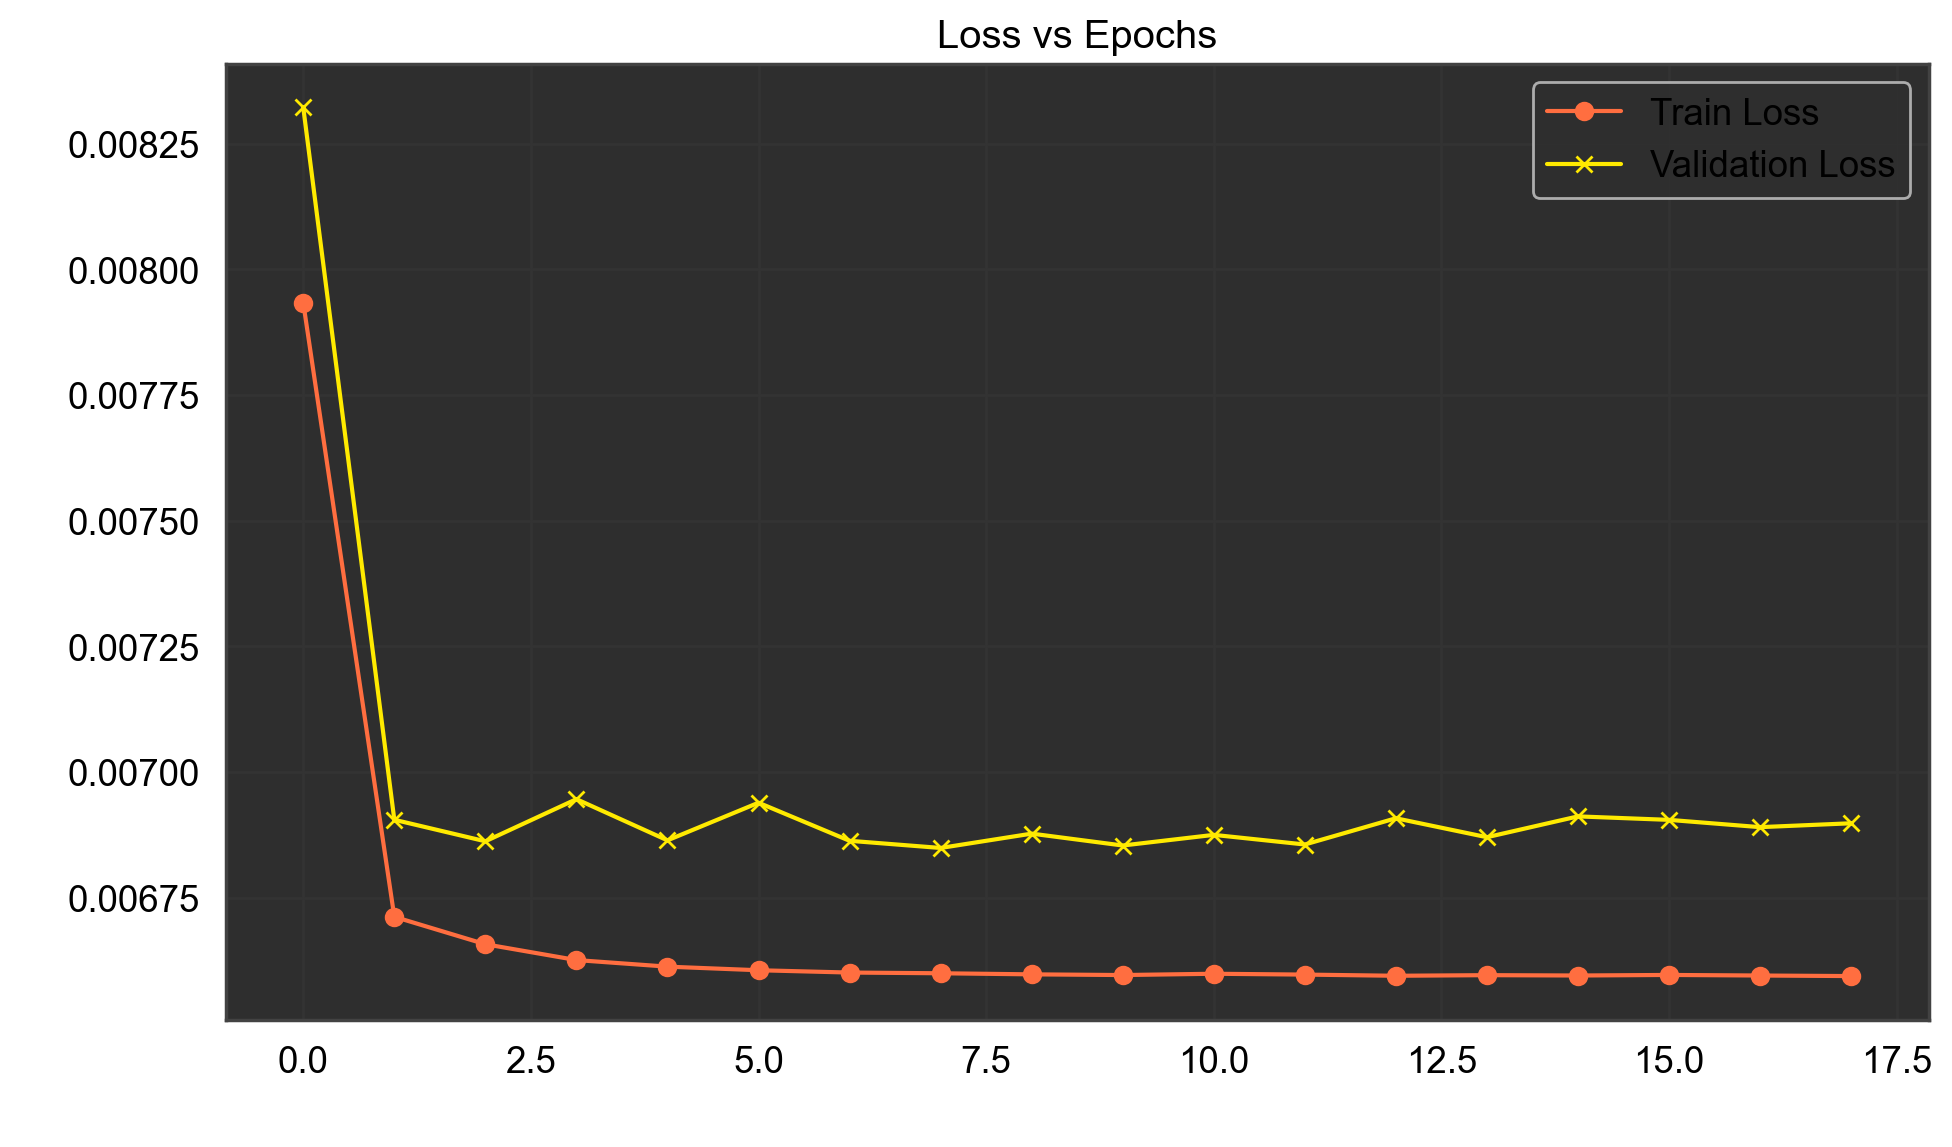

In [38]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10, path=checkpoint_path)

In [39]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode
predictions = evaluate_model(model, test_loader, checkpoint_path, device=device)

C:\Users\User\AppData\Local\Temp\ipykernel_27028\140456513.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Checkpoint loaded from ck_10/FreTS_alibaba.pth


Evaluating: 100%|██████████| 2147/2147 [00:27<00:00, 78.13it/s]


##### Evaluation Metrics #####
Test MAE         : 0.0603
Test RMSE        : 0.0831
Test Huber Loss  : 0.0035
Test MSE Loss    : 0.0069
Avg Inference Time per Sample: 0.0101 ms
Total Evaluation Time        : 1.39 seconds
